In [5]:
#Common Python Packages
from pickle import TRUE
import pickle
import numpy as np
import matplotlib.pyplot as plt
import timeout_decorator

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
base_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the random tests
recordings_path = os.path.join(base_path, "time_constant_recordings")

<font size=8> Extraction Process of single neuron 

The first index loop is the neuron  utilized
dict_keys([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
The second index is the leakage fine value utilized
dict_keys([40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88])


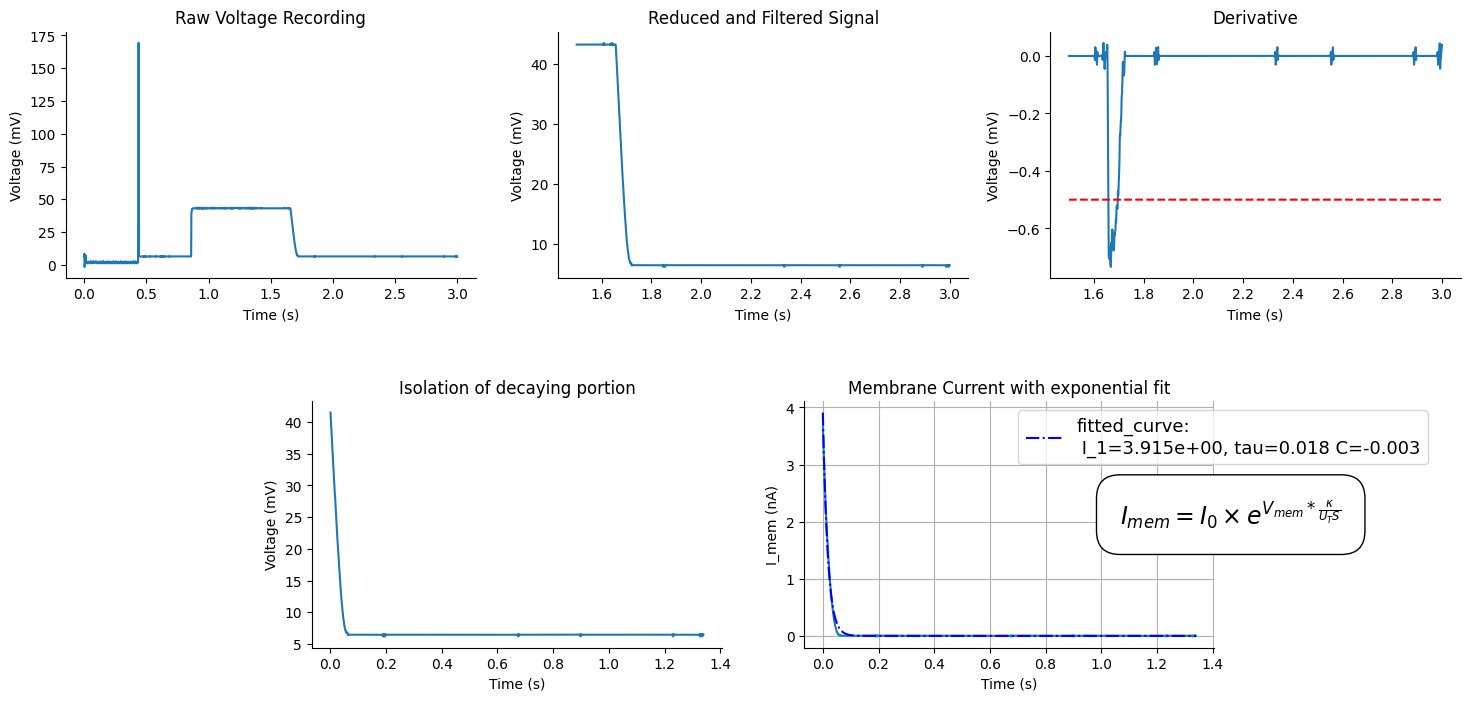

In [6]:
#switch current directory
os.chdir(recordings_path)
# Data structures
recordings_neuron_core_0_coarse_0 = np.load(
    'pulse_data_core_0_coarse_0.npy', allow_pickle=True).item()
recordings_neuron_core_0_coarse_1 = np.load(
    'pulse_data_core_0_coarse_1.npy', allow_pickle=True).item()
recordings_nueron_core_1_coarse_1 = np.load(
    'pulse_data_core_1_coarse_1.npy', allow_pickle=True).item()
recordings_neuron_core_2_coarse_1 = np.load(
    'pulse_data_core_2_coarse_1.npy', allow_pickle=True).item()
# Access the data for the first key of the outer dictionary
print('The first index loop is the neuron  utilized')
print(recordings_neuron_core_0_coarse_1.keys())
print('The second index is the leakage fine value utilized')
print(recordings_neuron_core_0_coarse_1[0].keys())
#first index is the neuron index, second index is the leakage fine value
time_constant_extraction(recordings_neuron_core_2_coarse_1[0][40], output='analysis', beta=1/26, cut_off=500, window_length=11, polyorder=3)


<font size=8> Double Graph of Time Constants in Cores and a Single Neuron

25
25
25
25
25
25


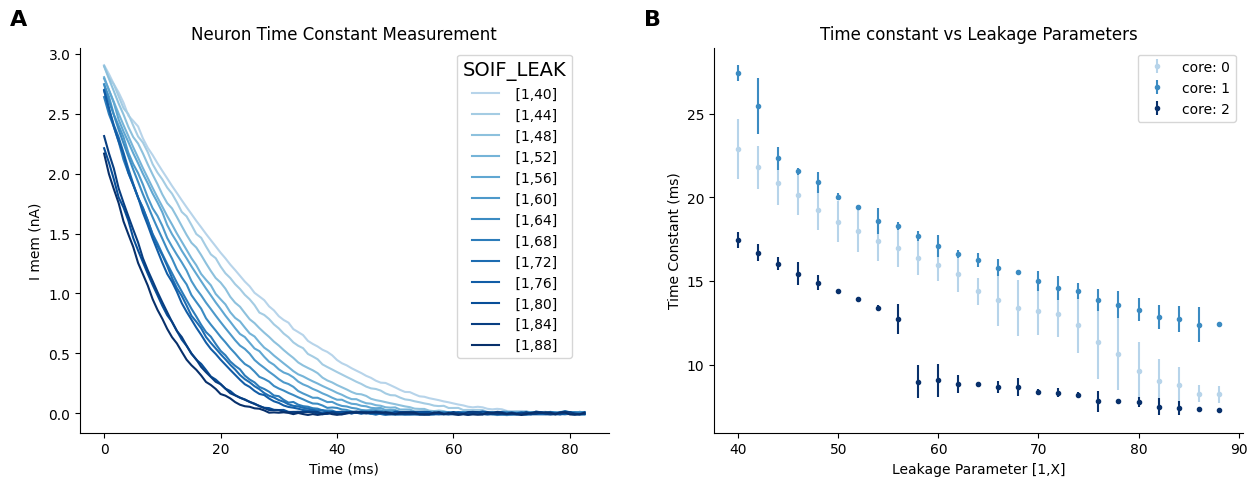

In [9]:



neurons=np.arange(0,95,5)
leak_range=np.arange(40,90,4)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Define a color map to generate colors for your lines
colors = cm.Blues(np.linspace(0.3, 1, len(leak_range)))
#plot in the first axes 
nueron=10
color_counter=0
for j in leak_range:
    [x,y]=time_constant_extraction(recordings_neuron_core_0_coarse_1[10][j],  output='curve', beta=1/26, cut_off=500, window_length=11, polyorder=3)
    ax1.plot(y[0:100]*1000,x[0:100], label=' [1,'+str(j)+']',color=colors[color_counter])
    color_counter=color_counter+1

# Create the legend box, and give it a title
legend = ax1.legend(bbox_to_anchor=(.7, 1), loc='upper left', fontsize=10, title="SOIF_LEAK")
plt.setp(legend.get_title(),fontsize=14)  # Setting legend title font size

ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('I mem (nA)')
ax1.set_title('Neuron Time Constant Measurement')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

leak_range=np.arange(40,90,2)
coarse_value=1

for i in range(3):
    time_constant_data_path = f'pulse_tc_data_core_{i}_coarse_1_n.npz'
    data = np.load(time_constant_data_path, allow_pickle=True)
    time_constant_data_matrix = data['time_constant_data_matrix']
    mean_time_constants = data['mean_time_constants']
    std_time_constants = data['std_time_constants']

    ax2.set_xlabel(f'Leakage Parameter [{coarse_value},X]')
    ax2.set_ylabel('Time Constant (ms)')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_title('Time constant vs Leakage Parameters')
    print(len(leak_range))
    print(len(mean_time_constants))
    # plot mean time constants with error bars representing standard deviation
    ax2.errorbar(leak_range, mean_time_constants, yerr=std_time_constants, fmt='.', label=f'core: {i}', color=colors[i*6])
# add an A and B label to the subplots
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='right')


    #save plot as svg
    #fig.savefig(f'time_constant_vs_leakage_core_{core}_coarse_{coarse_value}.svg', format='svg')
plt.legend()
plt.show()

<font size=8> To create Tables of the neuron time constants

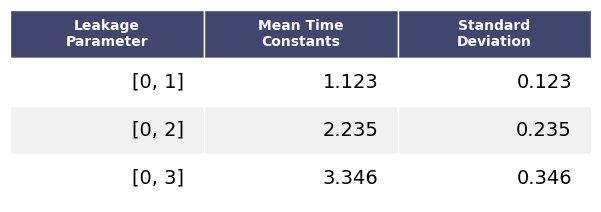

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import six
import numpy as np

data_dict = {
    'Leakage Parameter': [1, 2, 3],
    'Mean Time Constants': [1.123456, 2.234567, 3.345678],
    'Standard Deviation': [0.123456, 0.234567, 0.345678]
}

df = pd.DataFrame(data_dict)

# Round to 3 decimal places
df['Mean Time Constants'] = df['Mean Time Constants'].round(3)
df['Standard Deviation'] = df['Standard Deviation'].round(3)

# Format Leakage Parameter
df['Leakage Parameter'] = df['Leakage Parameter'].apply(lambda x: f'[0, {x}]')

# Rename columns with line breaks for text wrapping
df.columns = ['Leakage\nParameter',
              'Mean Time\nConstants', 'Standard\nDeviation']


def render_mpl_table(data, col_width=3.5, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            # smaller font for headers
            cell.set_text_props(weight='bold', color='w', size=10)
            cell.set_facecolor(header_color)
            cell._text.set_wrap(True)  # Enable text wrapping for headers
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax.get_figure(), ax


fig, ax = render_mpl_table(df, header_columns=0, col_width=2.5)
fig.savefig("table.png")


<font size=8> Improving the visualization

In [9]:

# Data structures
recordings_neuron_core_0_coarse_0 = np.load(
    os.path.join(recordings_path,'pulse_data_core_0_coarse_0.npy'), allow_pickle=True).item()
recordings_neuron_core_0_coarse_1 = np.load(
    os.path.join(recordings_path,'pulse_data_core_0_coarse_1.npy'), allow_pickle=True).item()
recordings_neuron_core_1_coarse_1 = np.load(
    os.path.join(recordings_path,'pulse_data_core_1_coarse_1.npy'), allow_pickle=True).item()
recordings_neuron_core_2_coarse_1 = np.load(
    os.path.join(recordings_path,'pulse_data_core_0_coarse_0.npy'), allow_pickle=True).item()


# Access the data for the first key of the outer dictionary
print('The first index loop is the neuron  utilized')
print(recordings_neuron_core_0_coarse_1.keys())
print('The second index is the leakage fine value utilized')
print(recordings_neuron_core_0_coarse_1[0].keys())
#first index is the neuron index, second index is the leakage fine value


The first index loop is the neuron  utilized
dict_keys([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
The second index is the leakage fine value utilized
dict_keys([40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88])


In [10]:
data=recordings_neuron_core_0_coarse_1[0][40]
beta=1/26
cut_off=500
window_length=11
polyorder=3

raw_voltage=data[0]*1000
raw_time=data[1]
time_mask = raw_time >= 1.5
time_masked = raw_time[time_mask]
voltage_masked = raw_voltage[time_mask]
sampling_rate = 1 / np.mean(np.diff(time_masked))  # Hz
cutoff_freq = cut_off # Hz
filter_order = 5
nyquist_freq = 0.5 * sampling_rate
cutoff_freq_normalized = cutoff_freq / nyquist_freq
b, a = butter(filter_order, cutoff_freq_normalized, btype='low')
voltage_filtered = filtfilt(b, a, voltage_masked)
peak_index = np.argmax(voltage_filtered)
# Smooth the data and take the derivative
voltage_smooth = savgol_filter(voltage_filtered, window_length, polyorder)
derivative = np.gradient(voltage_smooth)
# Find the start of the decay using the derivative
decay_start_index = None
decay_thresholds = [-2, -1, -0.5,-0.3, -0.1, -0.02, -0.01, -0.005]
for decay_threshold in decay_thresholds:
    for index in range(peak_index, len(derivative) - 1):
        if derivative[index] < decay_threshold and derivative[index + 1] < decay_threshold:
            decay_start_index = index
            break
    if decay_start_index is not None:
        break
if decay_start_index is None:
    # Decay not found, find index closest to 1.6 seconds
    target_time = 1.6
    closest_index = min(range(len(time_masked)), key=lambda i: abs(time_masked[i] - target_time))
    decay_start_index = closest_index
decay_start_index += 1
time_decay = time_masked[decay_start_index:]
time_decay = time_decay - time_decay[0]
I_mem = np.exp((voltage_filtered[decay_start_index:])*beta)
I_mem = I_mem - np.mean(I_mem[-500:])
def exp_func(t, A, tau,C):
    return A* np.exp(-t / tau)+C
# Initial guess for the parameters (A, tau)
initial_guess = [max(I_mem),1,0.02]
params, params_covariance = curve_fit(exp_func, time_decay, I_mem, p0=initial_guess,bounds=([0,0,-2], [np.inf,2, 2]))

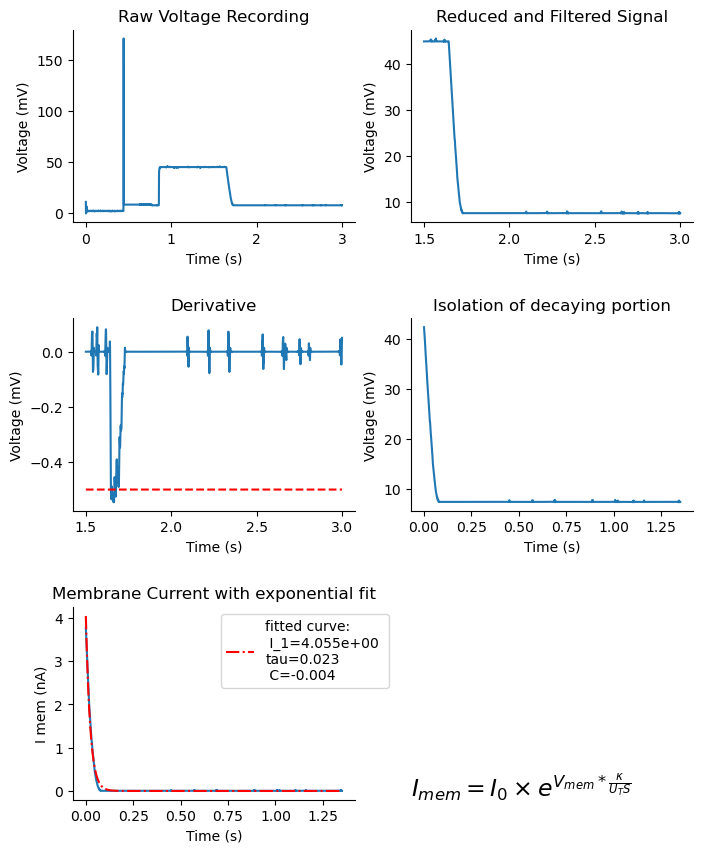

In [50]:
import matplotlib.gridspec as gridspec

def exp_func(t, A, tau,C):
    return A* np.exp(-t / tau)+C

fig = plt.figure(figsize=(8, 10))

# Create a gridspec object
gs = gridspec.GridSpec(3, 4)

ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[1, 0:2])
ax4 = plt.subplot(gs[1, 2:4])
ax5 = plt.subplot(gs[2, 0:2])

# You can adjust the spacing using subplots_adjust or tight_layout as mentioned in the previous responses.
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Plot raw voltage recording
ax1.plot(raw_time, raw_voltage)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (mV)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Raw Voltage Recording')

# Plot time and filtered voltage
ax2.plot(time_masked, voltage_filtered)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Voltage (mV)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Reduced and Filtered Signal')

#plot derivative
ax3.plot(time_masked,derivative)
ax3.plot(time_masked,decay_threshold*np.ones(len(time_masked)),'r--')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Voltage (mV)')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Derivative')


# Plot derivative
ax4.plot(time_decay,voltage_filtered[decay_start_index:])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Voltage (mV)')
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title('Isolation of decaying portion')

# Plot log voltage
ax5.plot(time_decay, I_mem)
# add font size
ax5.plot(time_decay, exp_func(time_decay, params[0], params[1], params[2]), 'r-.',
         label=f'fitted curve:\n I_1={params[0]:5.3e} \ntau={params[1]:5.3f}\n C={params[2]:5.3f} ')

ax5.set_xlabel('Time (s)')
ax5.set_ylabel('I mem (nA)')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title('Membrane Current with exponential fit')
ax5.legend(bbox_to_anchor=(.5, 1), loc='upper left',fontsize=10)
plt.text(1.2, .02, r'$I_{mem}=I_{0} \times e^{V_{mem}*\frac{\kappa}{U_TS}}$', fontsize=17,
        transform=plt.gca().transAxes)
# Show the plot
plt.show()